## Import Libraries

Import all the required Libraries

In [274]:

import os
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout

## Create Train and Test DF

Create Training and Testing Data Frames

In [196]:

ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants'
#ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants'
TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')


In [197]:

# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df


In [198]:
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

## EDA

Primilinary Exploratory Data Analysis

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [199]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

In [8]:
pd.read_csv(TRAIN_LABELS).isnull().sum()

solicitation_id                77
contract_award_number         824
document_name                   0
is_fitara                       0
contains_statement_of_work      0
dtype: int64

## NLTK Tokenization and Lemmatization

First, we need to remove the stop words, punctuation characters and all other special characters from the text.
Then, we need to lemmatize the word to it's root form.

In [477]:
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

stop_words = set(nltk.corpus.stopwords.words('english'))

# default tag is Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

lemma = WordNetLemmatizer()

words = train_df.loc[0, 'text']

def lemmatize(words):
    # Remove Stop words and keep only Alpha Numeric words
    words = [word.lower() for word in nltk.word_tokenize(words) if word.isalnum() and word.lower() not in stop_words]

    return ' '.join([lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(words)])

In [478]:
%%time

train_df['text'] = train_df.loc[:, 'text'].apply(lemmatize)
test_df['text'] = test_df.loc[:, 'text'].apply(lemmatize)

CPU times: user 2min 35s, sys: 344 ms, total: 2min 36s
Wall time: 2min 36s


## Util Functions

Some Utility Functions 

In [9]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [10]:
#set_no = get_set_from_word_list(train_df_temp)
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [411]:
def get_tf_idf(train_df, test_df):
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names() #pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()), X

## Ablation Experiment

Experimentation on a Smaller Dataset

In [479]:
train_df_no = train_df[train_df.is_fitara == 0]
train_df_yes = train_df[train_df.is_fitara == 1]

In [480]:
# Get 15% of total Records for Ablation
ablation = 0.15
train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation)]
train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation)]

In [481]:
train_df_ablation = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

X = train_df_ablation.drop(['is_fitara'], axis=1)
y = train_df_ablation['is_fitara']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [505]:
%%time
# X_train, X_test, feature_names = get_tf_idf(X_train_split['text'], X_test_split['text'])

# build pipeline
vectorizer = TfidfVectorizer()
regressor = SVC()

pipeline = Pipeline([('vectorizer', vectorizer), ('Logistic Regression', MultinomialNB(alpha=.01))])

# fit pipeline
pipeline.fit(X_train['text'], y_train)

# predict
y_pred = pipeline.predict(X_test['text'])

print(metrics.log_loss(y_test.values, y_pred))
print(y_pred)
print(y_test.values)


10.073909731527722
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0]
[1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
CPU times: user 63.9 ms, sys: 2.06 ms, total: 65.9 ms
Wall time: 64.5 ms


In [489]:
%%time

X_train_lr, X_test_lr, _ = get_tf_idf(X_train['text'], X_test['text'])
#model = SVC(kernel='linear', C=100, probability=True, random_state=32)
model = LogisticRegression()
model.fit(X_train_lr, y_train)

pred = model.predict(X_test_lr)
pred_proba = model.predict_proba(X_test_lr)

print(y_test.values)
print(pred)
print(np.round(pred_proba))

[1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
CPU times: user 69.9 ms, sys: 2.25 ms, total: 72.1 ms
Wall time: 70.7 ms


/Users/shabhushan/.local/share/virtualenvs/python-code-Ervzvb6E/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [416]:
# create model
model = Sequential()
model.add(Dense(50, input_dim=X_train.toarray().shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# train model
history = model.fit(X_train.toarray(), to_categorical(y_train, 2), epochs=400, batch_size=10, verbose=2)#, class_weight={1:0.96, 0:0.04})

Epoch 1/400
 - 2s - loss: 0.4845 - acc: 0.8194
Epoch 2/400
 - 0s - loss: 0.4710 - acc: 0.8194
Epoch 3/400
 - 0s - loss: 0.4598 - acc: 0.8194
Epoch 4/400
 - 0s - loss: 0.4694 - acc: 0.8194
Epoch 5/400
 - 0s - loss: 0.4584 - acc: 0.8194
Epoch 6/400
 - 0s - loss: 0.4575 - acc: 0.8194
Epoch 7/400
 - 0s - loss: 0.4531 - acc: 0.8194
Epoch 8/400
 - 0s - loss: 0.4481 - acc: 0.8194
Epoch 9/400
 - 0s - loss: 0.4258 - acc: 0.8194
Epoch 10/400
 - 0s - loss: 0.4403 - acc: 0.8194
Epoch 11/400
 - 0s - loss: 0.4307 - acc: 0.8194
Epoch 12/400
 - 0s - loss: 0.4228 - acc: 0.8194
Epoch 13/400
 - 0s - loss: 0.4268 - acc: 0.8194
Epoch 14/400
 - 0s - loss: 0.4277 - acc: 0.8194
Epoch 15/400
 - 0s - loss: 0.4141 - acc: 0.8194
Epoch 16/400
 - 0s - loss: 0.4016 - acc: 0.8194
Epoch 17/400
 - 0s - loss: 0.4073 - acc: 0.8194
Epoch 18/400
 - 0s - loss: 0.3831 - acc: 0.8194
Epoch 19/400
 - 0s - loss: 0.3867 - acc: 0.8194
Epoch 20/400
 - 0s - loss: 0.3681 - acc: 0.8194
Epoch 21/400
 - 0s - loss: 0.3662 - acc: 0.8194
E

Epoch 171/400
 - 0s - loss: 0.0085 - acc: 1.0000
Epoch 172/400
 - 0s - loss: 0.0076 - acc: 1.0000
Epoch 173/400
 - 0s - loss: 0.0083 - acc: 1.0000
Epoch 174/400
 - 0s - loss: 0.0082 - acc: 1.0000
Epoch 175/400
 - 0s - loss: 0.0080 - acc: 1.0000
Epoch 176/400
 - 0s - loss: 0.0068 - acc: 1.0000
Epoch 177/400
 - 0s - loss: 0.0079 - acc: 1.0000
Epoch 178/400
 - 0s - loss: 0.0106 - acc: 1.0000
Epoch 179/400
 - 0s - loss: 0.0073 - acc: 1.0000
Epoch 180/400
 - 0s - loss: 0.0068 - acc: 1.0000
Epoch 181/400
 - 0s - loss: 0.0097 - acc: 1.0000
Epoch 182/400
 - 0s - loss: 0.0070 - acc: 1.0000
Epoch 183/400
 - 0s - loss: 0.0071 - acc: 1.0000
Epoch 184/400
 - 0s - loss: 0.0066 - acc: 1.0000
Epoch 185/400
 - 0s - loss: 0.0077 - acc: 1.0000
Epoch 186/400
 - 0s - loss: 0.0070 - acc: 1.0000
Epoch 187/400
 - 0s - loss: 0.0060 - acc: 1.0000
Epoch 188/400
 - 0s - loss: 0.0067 - acc: 1.0000
Epoch 189/400
 - 0s - loss: 0.0066 - acc: 1.0000
Epoch 190/400
 - 0s - loss: 0.0065 - acc: 1.0000
Epoch 191/400
 - 0s 

 - 0s - loss: 0.0020 - acc: 1.0000
Epoch 339/400
 - 0s - loss: 0.0033 - acc: 1.0000
Epoch 340/400
 - 0s - loss: 0.0022 - acc: 1.0000
Epoch 341/400
 - 0s - loss: 0.0019 - acc: 1.0000
Epoch 342/400
 - 0s - loss: 0.0021 - acc: 1.0000
Epoch 343/400
 - 0s - loss: 0.0021 - acc: 1.0000
Epoch 344/400
 - 0s - loss: 0.0019 - acc: 1.0000
Epoch 345/400
 - 0s - loss: 0.0018 - acc: 1.0000
Epoch 346/400
 - 0s - loss: 0.0021 - acc: 1.0000
Epoch 347/400
 - 0s - loss: 0.0018 - acc: 1.0000
Epoch 348/400
 - 0s - loss: 0.0020 - acc: 1.0000
Epoch 349/400
 - 0s - loss: 0.0019 - acc: 1.0000
Epoch 350/400
 - 0s - loss: 0.0020 - acc: 1.0000
Epoch 351/400
 - 0s - loss: 0.0021 - acc: 1.0000
Epoch 352/400
 - 0s - loss: 0.0023 - acc: 1.0000
Epoch 353/400
 - 0s - loss: 0.0021 - acc: 1.0000
Epoch 354/400
 - 0s - loss: 0.0018 - acc: 1.0000
Epoch 355/400
 - 0s - loss: 0.0017 - acc: 1.0000
Epoch 356/400
 - 0s - loss: 0.0018 - acc: 1.0000
Epoch 357/400
 - 0s - loss: 0.0021 - acc: 1.0000
Epoch 358/400
 - 0s - loss: 0.0020

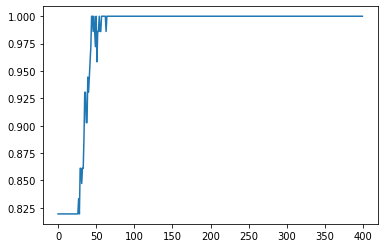

In [417]:
# plot metrics
plt.plot(history.history['acc'])
plt.show()

In [418]:
#print(y_test.values)
#print(pred)
#print(pred_proba)

num = metrics.log_loss(y_test.values, model.predict(X_test))


#math.exp(-num)
print(num)
print(math.exp(-num))
print(y_test.values)
print(np.round(model.predict(X_test)))

0.5867862403792969
0.556111625063531
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


100% Accuracy on Abration Experiment

## Model Running

Now we'll run the model on Full Data

In [338]:
X = train_df.drop(['is_fitara'], axis=1)
y = train_df['is_fitara']

X_train_split, X_test_split, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train, X_test, feature_names = get_tf_idf(X_train_split['text'], X_test_split['text'])

In [329]:
# create model
model = Sequential()
model.add(Dense(50, input_dim=X_train.toarray().shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# train model
history = model.fit(X_train.toarray(), to_categorical(y_train, 2), epochs=100, batch_size=10, verbose=2)#, class_weight={1:0.96, 0:0.04})

Epoch 1/100
 - 3s - loss: 0.6077 - acc: 0.7053
Epoch 2/100
 - 1s - loss: 0.5733 - acc: 0.7053
Epoch 3/100
 - 1s - loss: 0.5444 - acc: 0.7081
Epoch 4/100
 - 1s - loss: 0.5127 - acc: 0.7207
Epoch 5/100
 - 1s - loss: 0.4614 - acc: 0.7542
Epoch 6/100
 - 1s - loss: 0.4174 - acc: 0.8045
Epoch 7/100
 - 1s - loss: 0.3594 - acc: 0.8757
Epoch 8/100
 - 1s - loss: 0.3286 - acc: 0.8729
Epoch 9/100
 - 1s - loss: 0.2717 - acc: 0.9190
Epoch 10/100
 - 1s - loss: 0.2474 - acc: 0.9148
Epoch 11/100
 - 1s - loss: 0.2330 - acc: 0.9232
Epoch 12/100
 - 1s - loss: 0.2025 - acc: 0.9372
Epoch 13/100
 - 1s - loss: 0.1844 - acc: 0.9413
Epoch 14/100
 - 1s - loss: 0.1616 - acc: 0.9469
Epoch 15/100
 - 1s - loss: 0.1451 - acc: 0.9553
Epoch 16/100
 - 1s - loss: 0.1256 - acc: 0.9581
Epoch 17/100
 - 1s - loss: 0.1109 - acc: 0.9679
Epoch 18/100
 - 2s - loss: 0.1094 - acc: 0.9623
Epoch 19/100
 - 1s - loss: 0.0975 - acc: 0.9721
Epoch 20/100
 - 1s - loss: 0.0843 - acc: 0.9777
Epoch 21/100
 - 1s - loss: 0.0832 - acc: 0.9749
E

In [332]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 50)                2978250   
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_99 (Dense)             (None, 2)                 22        
Total params: 2,978,782
Trainable params: 2,978,782
Non-trainable params: 0
_________________________________________________________________


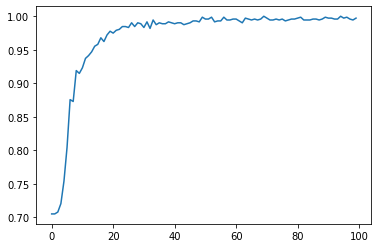

In [330]:
# plot metrics
plt.plot(history.history['acc'])
plt.show()

In [334]:
num = metrics.log_loss(y_test.values, model.predict(X_test))

#math.exp(-num)
print(num)
print(math.exp(-num))

#print(metrics.accuracy(y_test))

0.4847435276319344
0.6158551263337703


In [343]:
#X_train
pd.DataFrame(X_train.toarray(), columns = feature_names)

,00,000,0000,00000,000010111,0001,000100,0001001,0001002,0001003,...,ﬂute,ﬂuw,ﬂx_,ﬂxed,ﬂynlzm,ﬂz007,ﬂzi,ﬂzo06,ﬂﬂ,ﬂﬂullnn
0,0.010794,0.185563,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.004759,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001792,0.015401,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.026197,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.000000,0.024976,0.0,0.0,0.0,0.005113,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
712,0.079152,0.011018,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
713,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
714,0.001524,0.016549,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Decision Tree 

Random Forest 



In [23]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.log_loss(y_test, pred)
    print("accuracy:   %0.3f" % score)
    """
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        #if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()
    """
    #if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred))

    #if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [24]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.009s
test time:  0.000s
accuracy:   4.317
classification report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        21
           1       0.00      0.00      0.00         3

    accuracy                           0.88        24
   macro avg       0.44      0.50      0.47        24
weighted avg       0.77      0.88      0.82        24

confusion matrix:
[[21  0]
 [ 3  0]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
     

/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.014s
test time:  0.000s
accuracy:   5.756
classification report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.00      0.00      0.00         3

    accuracy                           0.83        24
   macro avg       0.43      0.48      0.45        24
weighted avg       0.76      0.83      0.80        24

confusion matrix:
[[20  1]
 [ 3  0]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_interc

/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shashi/.local/share/virtualenvs/python-code-gqSjhHCu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


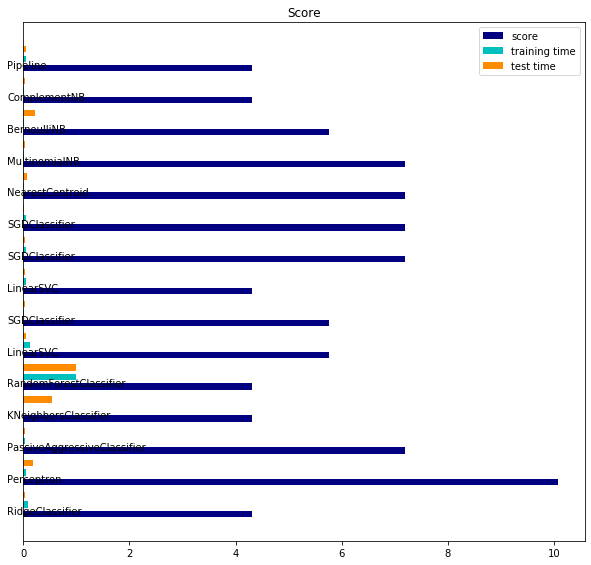

In [26]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()